In [2]:
import numpy as np
import pandas as pd
import datetime
import time
from demand_model import *
import pywt
from utils import *
from uncertainty_process import *
%matplotlib inline

In [3]:
## create DemandFile object, get basic date from it, date, date_ud, cusid, cusid_ud, and dataframe
Demandbase = DemandFile('SelectedDataFor1EE.xlsx', 'Sheet1')
Date = Demandbase.getDate()
Date_ud = Demandbase.getDate_ud()
CusID = Demandbase.getCusID()
CusID_ud = Demandbase.getCusID_ud()

[1331, 1807, 2529, 2654, 2702, 3593, 4176, 4637, 6810, 7274]
(1350, 48)
10
135
umlist size: 11


ValueError: too many values to unpack

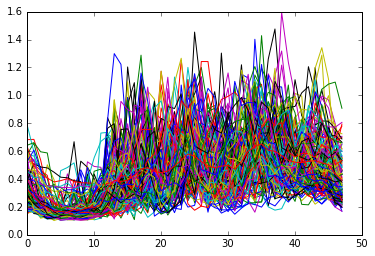

In [4]:
file_lp_all = './result/load_profiles_all'
file_lp_allcus_allyear = './result/load_profiles_allcus_allyear'
file_lp_mean_allyear = './result/load_profiles_mean_allyear'
file_lp_sum_allyear = './result/load_profiles_sum_allyear'
file_lp_daily_sum = './result/load_profiles_sum_daily.csv'
file_lp_daily_mean = './result/load_profiles_mean_daily.csv'



def inlist(dm,CLT):
    idbase = (dm['CustomerID'] == 0)
    for ind in CLT:
        tmpid = (dm['CustomerID'] == ind)
        idbase = idbase | tmpid
    return idbase
def rateCal(mlist):
    ori = np.mean(mlist[:-1])
    new = mlist[-1]
    rate = (ori - new)/ori
    return rate
import random
## setting data use parameters, set customers and dates which is taken into consideration
modset_c = ['fixed','period','list']
modset_d = ['fixed','period','list']
Cus = 1002
CusStart = 1002
CusEnd = 1016
Date = '2009-07-14' # this is a Monday
DateStart = '2009-09-04' ## including
DateEnd = '2010-01-17' ## not including, start from friday, then end on friday
DateList = ['2009-07-14', '2009-07-19']
DCL = 3 # decomposition level
## setting mode and get considering data
mod_c = 'list'
mod_d = 'period'
agmod = 'mean'
aggregation_size = 929

iter_round = np.floor(929/aggregation_size) + 0
iter_round = iter_round.astype(int)
red_h = []
red_m = []
red_l = []
for _ in range(iter_round):
    ## initiate database
    Demand = Demandbase.getDataframeAll()
    indlist = random.sample(range(0,929), 10)
    indlist = np.sort(indlist)
    CusList = []
    for i_ind in indlist:
        CusList.append(CusID_ud[i_ind])
    # get data which comply with customer id conditions first, use switch code
    for case in switch(mod_c):
        if case('fixed'):
            Demand = Demand[(Demand['CustomerID'] == Cus)]
            break
        if case('period'):
            Demand = Demand[(Demand['CustomerID'] >= CusStart) & (Demand['CustomerID'] < CusEnd)]
            break
        if case('list'):
            print CusList
            ils = inlist(Demand, CusList)
            Demand = Demand[inlist(Demand, CusList)]
            break
        if case():
            print "mod_c setting error #1"

    # get data which comply with date condition, then left only data comply with both cusid and date
    for case in switch(mod_d):
        if case('fixed'):
            Demand = Demand[(Demand['Date'] == Date)]
            break
        if case('period'):
            Demand = Demand[(Demand['Date'] >= DateStart) & (Demand['Date'] < DateEnd)]
            break
        if case('list'):
            Demand = Demand[(Demand['Date'] in DateList)]
            break
        if case():# default, could also just omit condition or 'if True'
            print "mod_d setting error #2"
            # No need to break here, it'll stop anyway
    Demand0 = Demand[(Demand['CustomerID'] == CusStart)]
    Demand0['CustomerID'] = 1000
    db = np.array(Demand)[:,2:] ## selected N customers load profiles
    print db.shape
    cuscount = len(indlist)
    print cuscount
    db1 = db.reshape((cuscount, -1))
    db2_mean = np.mean(db1, axis = 0)
    db2_sum = np.sum(db1, axis = 0)
    db3_mean = db2_mean.reshape((-1, 48))
    db3_sum = db2_sum.reshape((-1,48))
    if agmod == 'mean':
        db3 = db2_mean.reshape((-1, 48))
    else: 
        db3 = db2_sum.reshape((-1,48))    
    aggregated_load = db3
    days = db3.shape[0]
    print days
    for i in range(days):
        plot(range(48), db3[i])
    plot(range(48),np.mean(db3, axis = 0))
    pd.DataFrame(db).to_csv(file_lp_all)
    pd.DataFrame(db1).to_csv(file_lp_allcus_allyear)
    pd.DataFrame(db2_mean).to_csv(file_lp_mean_allyear)
    pd.DataFrame(db2_sum).to_csv(file_lp_sum_allyear)
    pd.DataFrame(db3_mean).to_csv(file_lp_daily_mean)
    pd.DataFrame(db3_sum).to_csv(file_lp_daily_sum)

    ## uc modelling step 1, decomposition
    umlist = []
    umlist0 = []
    for cusind in indlist:
        cus = CusID_ud[cusind]
        inputframe = Demand[(Demand['CustomerID'] == cus)]
        inputs = np.array(inputframe)[:,2:]
        uclist = uc_process(inputs, DCL)
        umlist.append(UncertaintyModel(Cus,uclist))
    uclist = uc_process(aggregated_load, DCL)
    umlist.append(UncertaintyModel(1000, uclist))
    print 'umlist size: ' + str(len(umlist))
    def uc_analysis(UMList):
        meanlist1 = []
        meanlist2 = []
        meanlist3 = []
        datelist1 = []
        datelist2 = []
        datelist3 = []
        tpntlist1 = []
        tpntlist2 = []
        tpntlist3 = []
        count = len(UMList)
        for ind in range(count):
            lv = UMList[ind].getlv()
            if lv == 3:
                (mean1, mean2, mean3, date1, date2, date3, tpnt1, tpnt2, tpnt3) = UMList[ind].getuc()
                meanlist1.append(mean1)
                meanlist2.append(mean2)
                meanlist3.append(mean3)
                datelist1.append(date1)
                datelist2.append(date2)
                datelist3.append(date3)
                tpntlist1.append(tpnt1)
                tpntlist2.append(tpnt2)
                tpntlist3.append(tpnt3)
        return (meanlist1,meanlist2,meanlist3,datelist1,datelist2,datelist3,tpntlist1,tpntlist2,tpntlist3)

    (meanlist1,meanlist2,meanlist3,datelist1,datelist2,datelist3,tpntlist1,tpntlist2,tpntlist3) = uc_analysis(umlist)
    #meanlist1 # for 5 cus, 4 days, only 5 values for each cus, draw line chart in single figure
    #datelist1 # for 5 cus, 4 days, 5 X 4 matrix, draw 2d surface figure to show, and 3 level in single figure, and also average along customers, to find uc in different dates
    #tpntlist1 # for 5 cus, 4 days, 5 X 48 matrix, draw 2d surface figure to show, and 3 level in single figure, and also average along custoemrs, to find uc in different time points
    red_h.append(rateCal(meanlist1))
    red_m.append(rateCal(meanlist2))
    red_l.append(rateCal(meanlist3))

"""
uc_customer(meanlist1[:-1], meanlist2[:-1], meanlist3[:-1])
print '''
************************
'''

print 'aggregated std in high Freq. level: ' + str(meanlist1[-1])
print 'aggregated std in mid Freq. level: ' + str(meanlist2[-1])
print 'aggregated std in low Freq. level: ' + str(meanlist3[-1])
print '''
************************
'''
"""

print 'Propogation Reduction Rate in high Freq. level: ' + str(np.mean(red_h))
print 'Propogation Reduction Rate in mid Freq. level: ' + str(np.mean(red_m))
print 'Propogation Reduction Rate in low Freq. level: ' + str(np.mean(red_l))

In [ ]:
#===============
#  Color map configuration compare
#===============
# three pre-selected color maps to visualise data

#list_all_color_config(datelist1)
#list_all_color_config_3d(datelist1)

#colortype1 = cm.Blues
#colortype2 = cm.PiYG
#colortype3 = cm.PuRd
#trycolor(datelist3,colortype1)
#trycolor(datelist3,colortype2)
#trycolor(datelist3,colortype3)
#trycolor(datelist2)
print "For convenience, we use Blues color map as default in the following"

In [ ]:
#===============
#  date difference comparison
#===============
# here separate the uncertainty along with differing dates and customers, to show how uncertainty quantities changes.
from utils import uc_parameters_customer_heat
uc_parameters_customer_3d(datelist1)
uc_parameters_customer_heat(datelist1)
uc_parameters_customer_3d(datelist2)
uc_parameters_customer_heat(datelist2)
uc_parameters_customer_3d(datelist3)
uc_parameters_customer_heat(datelist3)

#===============
# subplot 2
#===============
# 2D analysis, customers average along with differing dates
uc_parameters(datelist1)
uc_dayofweek(datelist1)
uc_parameters(datelist2)
uc_dayofweek(datelist2)
uc_parameters(datelist3)
uc_dayofweek(datelist3)


In [ ]:
#===============
#  date difference comparison
#===============
# here separate the uncertainty along with differing dates and customers, to show how uncertainty quantities changes.

uc_parameters_customer_3d(tpntlist1)
uc_parameters_customer_heat(tpntlist1)
uc_parameters_customer_3d(tpntlist2)
uc_parameters_customer_heat(tpntlist2)
uc_parameters_customer_3d(tpntlist3)
uc_parameters_customer_heat(tpntlist3)

#===============
# subplot 2
#===============
# 2D analysis, customers average along with differing dates
uc_parameters(tpntlist1)
uc_parameters(tpntlist2)
uc_parameters(tpntlist3)